**Model and Data Preparation**

In [1]:

import math
import random
import time
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# Try to import torchvision; fallback to synthetic dataset if missing.
try:
    from torchvision import datasets, transforms
    has_torchvision = True
except Exception as e:
    print("torchvision import failed, falling back to synthetic dataset. Error:", e)
    has_torchvision = False

# ----------------- Utilities -----------------
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def model_size_bytes(model):
    return sum(p.numel() * p.element_size() for p in model.parameters())

def compute_sparsity(model):
    total = 0
    zeros = 0
    for p in model.parameters():
        if p.requires_grad:
            total += p.numel()
            zeros += (p.data == 0).sum().item()
    return zeros / total if total>0 else 0.0


# ----------------- Tiny ViT-style model -----------------
class PatchEmbedding(nn.Module):
    def __init__(self, in_ch=3, patch_size=4, emb_dim=64, img_size=32):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_ch, emb_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x

class TinyAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        assert emb_dim % num_heads == 0
        self.head_dim = emb_dim // num_heads
        self.qkv = nn.Linear(emb_dim, emb_dim * 3)
        self.out = nn.Linear(emb_dim, emb_dim)
    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        score = (q @ k.transpose(-2,-1)) / math.sqrt(self.head_dim)
        att = F.softmax(score, dim=-1)
        out = (att @ v).transpose(1,2).reshape(B, N, D)
        return self.out(out)

class TinyMLP(nn.Module):
    def __init__(self, emb_dim, mlp_factor=2):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, emb_dim * mlp_factor)
        self.fc2 = nn.Linear(emb_dim * mlp_factor, emb_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, mlp_factor=2, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_dim)
        self.attn = TinyAttention(emb_dim, num_heads)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = TinyMLP(emb_dim, mlp_factor)
    def forward(self, x, fifo_sim=None, tile_size=None):
        # If fifo_sim True and tile_size provided, process tokens in tiles to simulate FIFO streaming.
        if fifo_sim and tile_size is not None:
            B, N, D = x.shape
            out_tokens = []
            for i in range(0, N, tile_size):
                chunk = x[:, i:i+tile_size, :]
                chunk = chunk + self.attn(self.norm1(chunk))
                chunk = chunk + self.mlp(self.norm2(chunk))
                out_tokens.append(chunk)
                fifo_sim.append(chunk.detach())  # producer writes chunk to FIFO (simulation)
            x_new = torch.cat(out_tokens, dim=1)
            return x_new
        else:
            y = x + self.attn(self.norm1(x))
            y = y + self.mlp(self.norm2(y))
            return y

class TinyTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_ch=3, emb_dim=64, depth=4, num_heads=4, mlp_factor=2, n_classes=10):
        super().__init__()
        self.patch = PatchEmbedding(in_ch, patch_size, emb_dim, img_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.patch.n_patches, emb_dim))
        self.layers = nn.ModuleList([TransformerBlock(emb_dim, num_heads, mlp_factor) for _ in range(depth)])
        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Linear(emb_dim, n_classes)

    def forward(self, x, fifo_sim=False, tile_size=None):
        B = x.shape[0]
        x = self.patch(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1) + self.pos_embed

        # ✅ FIX: create a real deque when fifo_sim=True
        fifo = deque(maxlen=4) if fifo_sim else None

        for layer in self.layers:
            x = layer(x, fifo_sim=fifo, tile_size=tile_size)  # pass actual deque or None

        x = self.norm(x)
        cls_final = x[:,0]
        return self.head(cls_final)



# ----------------- SparseNAS-style magnitude pruning -----------------
def magnitude_prune_global(model, target_sparsity):
    all_weights = torch.cat([p.data.abs().flatten() for p in model.parameters() if p.requires_grad])
    k = int(all_weights.numel() * target_sparsity)
    if k == 0:
        return None
    threshold = all_weights.kthvalue(k).values.item()
    masks = {}
    for name, p in model.named_parameters():
        if p.requires_grad:
            mask = (p.data.abs() > threshold).float()
            p.data.mul_(mask)
            masks[name] = mask
    return masks

def apply_mask(model, masks):
    if masks is None:
        return
    for name, p in model.named_parameters():
        if name in masks:
            p.data.mul_(masks[name])

# ----------------- SOAQ PoT quantization (STE) -----------------
class PoTQuantizer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, n_bits=4, signed=True, eps=1e-12):
        ctx.save_for_backward(x)
        sign = x.sign()
        mag = x.abs().clamp(min=eps)
        exponent = mag.log2().round()
        q = sign * (2.0 ** exponent)
        max_exp = 2**(n_bits-1) - 1
        min_exp = -max_exp
        q = sign * (2.0 ** exponent.clamp(min=min_exp, max=max_exp))
        q[(mag < 2.0 ** min_exp).squeeze()] = 0.0
        return q
    @staticmethod
    def backward(ctx, grad_output):
        (x,) = ctx.saved_tensors
        return grad_output, None, None, None

def pot_quantize_tensor(x, n_bits=4):
    return PoTQuantizer.apply(x, n_bits)

class QuantLinear(nn.Module):
    def __init__(self, linear_module, n_bits=4):
        super().__init__()
        self.linear = linear_module
        self.n_bits = n_bits
    def forward(self, x):
        qW = pot_quantize_tensor(self.linear.weight, self.n_bits)
        if self.linear.bias is not None:
            qB = pot_quantize_tensor(self.linear.bias, self.n_bits)
        else:
            qB = None
        return F.linear(x, qW, qB)

def quantize_model_inplace(model, n_bits=4):
    # recursively replace Linear modules with QuantLinear wrappers
    for name, module in list(model.named_children()):
        if isinstance(module, nn.Linear):
            setattr(model, name, QuantLinear(module, n_bits=n_bits))
        else:
            quantize_model_inplace(module, n_bits=n_bits)

# ----------------- Training / evaluation / inference -----------------
def train_one_epoch(model, optimizer, loader, epoch, device, qn_bits=4, fifo_tile=None):
    model.train()
    total_loss = 0.0
    total = 0
    correct = 0
    for i, (x,y) in enumerate(loader):
        x = x.to(device); y = y.to(device)
        optimizer.zero_grad()
        logits = model(x, fifo_sim=(fifo_tile is not None), tile_size=fifo_tile)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total += x.size(0)
        correct += (preds == y).sum().item()
    return total_loss/total, correct/total

def evaluate(model, loader, device, fifo_tile=None):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device); y = y.to(device)
            logits = model(x, fifo_sim=(fifo_tile is not None), tile_size=fifo_tile)
            preds = logits.argmax(dim=1)
            total += x.size(0)
            correct += (preds == y).sum().item()
    return correct/total

def inference_single(model, img_tensor, device, fifo_tile=None):
    model.eval()
    with torch.no_grad():
        x = img_tensor.unsqueeze(0).to(device)
        logits = model(x, fifo_sim=(fifo_tile is not None), tile_size=fifo_tile)
        probs = F.softmax(logits, dim=1)
        pred = logits.argmax(dim=1).item()
    return pred, probs.squeeze(0).cpu().numpy()

# ----------------- Data loaders (CIFAR-10 or synthetic fallback) -----------------
def get_cifar10_dataloaders(batch_size=64, subset_train=4000, subset_val=1000):
    if has_torchvision:
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
        ])
        transform_test = transforms.Compose([transforms.ToTensor()])
        trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
        testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
        train_subset = Subset(trainset, list(range(min(subset_train, len(trainset)))))
        val_subset = Subset(trainset, list(range(min(subset_train, len(trainset)), min(subset_train+subset_val, len(trainset)))))
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    else:
        print("Creating synthetic dataset (CIFAR-10 like) for demo.")
        num_train = subset_train
        num_val = subset_val
        num_test = 1000
        X_train = torch.randn(num_train, 3, 32, 32)
        y_train = torch.randint(0, 10, (num_train,))
        X_val = torch.randn(num_val, 3, 32, 32)
        y_val = torch.randint(0, 10, (num_val,))
        X_test = torch.randn(num_test, 3, 32, 32)
        y_test = torch.randint(0, 10, (num_test,))
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

# ----------------- proxy SuperNAS: random search -----------------
def random_search_supernet(search_space, train_loader, val_loader, budget=4, epochs=1, device=device):
    best = None
    best_acc = -1.0
    for i in range(budget):
        cfg = random.choice(search_space)
        print(f"\n[Search {i+1}/{budget}] Trying config: {cfg}")
        model = TinyTransformer(img_size=32, patch_size=4, emb_dim=cfg['emb_dim'], depth=cfg['depth'],
                                num_heads=cfg['num_heads'], mlp_factor=cfg['mlp_factor']).to(device)
        print(" Params:", count_parameters(model), " Size (bytes):", model_size_bytes(model))
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        for e in range(epochs):
            train_one_epoch(model, optimizer, train_loader, e, device, fifo_tile=None)
        acc = evaluate(model, val_loader, device)
        print(" Validation acc:", acc)
        if acc > best_acc:
            best_acc = acc
            best = (cfg, model)
    return best, best_acc

# ----------------- Full pipeline runner -----------------
def run_pipeline(seed=42, quick_mode=True):
    random.seed(seed); torch.manual_seed(seed)
    batch_size = 64
    train_loader, val_loader, test_loader = get_cifar10_dataloaders(batch_size=batch_size,
                                                                    subset_train=2000 if quick_mode else 40000,
                                                                    subset_val=500 if quick_mode else 5000)
    search_space = [
        {'emb_dim':64, 'depth':2, 'num_heads':2, 'mlp_factor':2},
        {'emb_dim':64, 'depth':3, 'num_heads':2, 'mlp_factor':2},
        {'emb_dim':128, 'depth':3, 'num_heads':4, 'mlp_factor':2},
        {'emb_dim':128, 'depth':4, 'num_heads':4, 'mlp_factor':2},
        {'emb_dim':64, 'depth':4, 'num_heads':4, 'mlp_factor':2},
    ]
    (best_cfg, best_model), best_acc = random_search_supernet(search_space, train_loader, val_loader, budget=4, epochs=1, device=device)
    print("\nSelected architecture:", best_cfg, "val_acc:", best_acc)
    model = best_model
    # SparseNAS-style pruning
    target_sparsity = 0.6
    print("\nApplying global magnitude pruning to target sparsity", target_sparsity)
    masks = magnitude_prune_global(model, target_sparsity)
    print("Sparsity after prune (measured):", compute_sparsity(model))
    # Fine-tune a bit
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    for e in range(2):
        train_one_epoch(model, optimizer, train_loader, e, device)
    val_acc_post_prune = evaluate(model, val_loader, device)
    print("Validation acc after pruning & fine-tune:", val_acc_post_prune)
    # SOAQ quantization (QAT)
    qn_bits = 4
    print("\nApplying PoT quantization wrappers (n_bits=", qn_bits, ")")
    quantize_model_inplace(model, n_bits=qn_bits)
    apply_mask(model, masks)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    for e in range(2):
        train_one_epoch(model, optimizer, train_loader, e, device)
    val_acc_post_qat = evaluate(model, val_loader, device)
    print("Validation acc after PoT-QAT:", val_acc_post_qat)
    # FIFO token-tiling simulation
    fifo_tile = 8
    print("\nEvaluating with FIFO-token-tiling simulation (tile_size=%d)" % fifo_tile)
    val_acc_fifo = evaluate(model, val_loader, device, fifo_tile=fifo_tile)
    print("Validation acc with FIFO simulation:", val_acc_fifo)
    # Final test
    test_acc = evaluate(model, test_loader, device, fifo_tile=fifo_tile)
    final_sparsity = compute_sparsity(model)
    param_count = count_parameters(model)
    size_bytes = model_size_bytes(model)
    print("\n=== Final Results ===")
    print("Test accuracy:", test_acc)
    print("Validation accuracy (post-QAT):", val_acc_post_qat)
    print("Parameter count:", param_count)
    print("Model size (bytes):", size_bytes)
    print("Measured sparsity:", final_sparsity)
    test_iter = iter(test_loader)
    imgs, labels = next(test_iter)
    img0 = imgs[0]
    pred, probs = inference_single(model, img0, device, fifo_tile=fifo_tile)
    print("Example inference -> label:", labels[0].item(), "pred:", pred)
    results = {
        'test_acc': test_acc,
        'val_acc_post_qat': val_acc_post_qat,
        'param_count': param_count,
        'size_bytes': size_bytes,
        'sparsity': final_sparsity,
        'best_cfg': best_cfg,
    }
    return model, results

if __name__ == "__main__":
    t0 = time.time()
    model, results = run_pipeline(seed=123, quick_mode=True)
    t1 = time.time()
    print("Pipeline runtime (s):", t1-t0)
    print("Results:", results)


Running on device: cuda


100%|██████████| 170M/170M [00:06<00:00, 26.1MB/s]



[Search 1/4] Trying config: {'emb_dim': 64, 'depth': 2, 'num_heads': 2, 'mlp_factor': 2}
 Params: 75082  Size (bytes): 300328
 Validation acc: 0.13

[Search 2/4] Trying config: {'emb_dim': 128, 'depth': 3, 'num_heads': 4, 'mlp_factor': 2}
 Params: 413706  Size (bytes): 1654824
 Validation acc: 0.166

[Search 3/4] Trying config: {'emb_dim': 64, 'depth': 2, 'num_heads': 2, 'mlp_factor': 2}
 Params: 75082  Size (bytes): 300328
 Validation acc: 0.146

[Search 4/4] Trying config: {'emb_dim': 128, 'depth': 4, 'num_heads': 4, 'mlp_factor': 2}
 Params: 546186  Size (bytes): 2184744
 Validation acc: 0.176

Selected architecture: {'emb_dim': 128, 'depth': 4, 'num_heads': 4, 'mlp_factor': 2} val_acc: 0.176

Applying global magnitude pruning to target sparsity 0.6
Sparsity after prune (measured): 0.5999989014731245
Validation acc after pruning & fine-tune: 0.212

Applying PoT quantization wrappers (n_bits= 4 )
Validation acc after PoT-QAT: 0.24

Evaluating with FIFO-token-tiling simulation (tile_

**Full-scale run for maximum accuracy**

In [2]:


# Full-scale run for maximum accuracy
model, results = run_pipeline(seed=123, quick_mode=False)



[Search 1/4] Trying config: {'emb_dim': 64, 'depth': 2, 'num_heads': 2, 'mlp_factor': 2}
 Params: 75082  Size (bytes): 300328
 Validation acc: 0.3082

[Search 2/4] Trying config: {'emb_dim': 128, 'depth': 3, 'num_heads': 4, 'mlp_factor': 2}
 Params: 413706  Size (bytes): 1654824
 Validation acc: 0.344

[Search 3/4] Trying config: {'emb_dim': 64, 'depth': 2, 'num_heads': 2, 'mlp_factor': 2}
 Params: 75082  Size (bytes): 300328
 Validation acc: 0.297

[Search 4/4] Trying config: {'emb_dim': 128, 'depth': 4, 'num_heads': 4, 'mlp_factor': 2}
 Params: 546186  Size (bytes): 2184744
 Validation acc: 0.3216

Selected architecture: {'emb_dim': 128, 'depth': 3, 'num_heads': 4, 'mlp_factor': 2} val_acc: 0.344

Applying global magnitude pruning to target sparsity 0.6
Sparsity after prune (measured): 0.5999985496947108
Validation acc after pruning & fine-tune: 0.4176

Applying PoT quantization wrappers (n_bits= 4 )
Validation acc after PoT-QAT: 0.453

Evaluating with FIFO-token-tiling simulation (

**Finding Best Config**

In [3]:
# Larger-scale setup
train_loader, val_loader, test_loader = get_cifar10_dataloaders(batch_size=128,
                                                                subset_train=40000,
                                                                subset_val=5000)

search_space = [
    {'emb_dim': 64, 'depth': 3, 'num_heads': 2, 'mlp_factor': 2},
    {'emb_dim': 128, 'depth': 4, 'num_heads': 4, 'mlp_factor': 2},
    {'emb_dim': 192, 'depth': 6, 'num_heads': 6, 'mlp_factor': 2},
    {'emb_dim': 256, 'depth': 8, 'num_heads': 8, 'mlp_factor': 2},
]

# === SuperNAS Search (more candidates, more epochs) ===
(best_cfg, best_model), best_acc = random_search_supernet(
    search_space, train_loader, val_loader, budget=6, epochs=5
)

print("Best configuration:", best_cfg)



[Search 1/6] Trying config: {'emb_dim': 192, 'depth': 6, 'num_heads': 6, 'mlp_factor': 2}
 Params: 1806538  Size (bytes): 7226152
 Validation acc: 0.4284

[Search 2/6] Trying config: {'emb_dim': 64, 'depth': 3, 'num_heads': 2, 'mlp_factor': 2}
 Params: 108554  Size (bytes): 434216
 Validation acc: 0.4134

[Search 3/6] Trying config: {'emb_dim': 64, 'depth': 3, 'num_heads': 2, 'mlp_factor': 2}
 Params: 108554  Size (bytes): 434216
 Validation acc: 0.4232

[Search 4/6] Trying config: {'emb_dim': 256, 'depth': 8, 'num_heads': 8, 'mlp_factor': 2}
 Params: 4249354  Size (bytes): 16997416
 Validation acc: 0.3496

[Search 5/6] Trying config: {'emb_dim': 192, 'depth': 6, 'num_heads': 6, 'mlp_factor': 2}
 Params: 1806538  Size (bytes): 7226152
 Validation acc: 0.4368

[Search 6/6] Trying config: {'emb_dim': 192, 'depth': 6, 'num_heads': 6, 'mlp_factor': 2}
 Params: 1806538  Size (bytes): 7226152
 Validation acc: 0.4244
Best configuration: {'emb_dim': 192, 'depth': 6, 'num_heads': 6, 'mlp_facto

**Pruning**

In [4]:
# Apply pruning
target_sparsity = 0.6
masks = magnitude_prune_global(best_model, target_sparsity)
print("Sparsity after pruning:", compute_sparsity(best_model))

# Fine-tune longer (e.g., 10–20 epochs)
optimizer = torch.optim.Adam(best_model.parameters(), lr=5e-4)
for e in range(10):
    loss, acc = train_one_epoch(best_model, optimizer, train_loader, e, device)
    print(f"Epoch {e+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

val_acc = evaluate(best_model, val_loader, device)
print("Validation accuracy after fine-tune:", val_acc)


Sparsity after pruning: 0.5999995571640342
Epoch 1 | Loss: 1.4760 | Acc: 0.4649
Epoch 2 | Loss: 1.4308 | Acc: 0.4798
Epoch 3 | Loss: 1.3963 | Acc: 0.4931
Epoch 4 | Loss: 1.3695 | Acc: 0.5036
Epoch 5 | Loss: 1.3478 | Acc: 0.5109
Epoch 6 | Loss: 1.3150 | Acc: 0.5237
Epoch 7 | Loss: 1.3023 | Acc: 0.5301
Epoch 8 | Loss: 1.2827 | Acc: 0.5389
Epoch 9 | Loss: 1.2680 | Acc: 0.5406
Epoch 10 | Loss: 1.2427 | Acc: 0.5517
Validation accuracy after fine-tune: 0.5278


**Apply QAT**

In [5]:
# Apply quantization wrappers (QAT)
quantize_model_inplace(best_model, n_bits=4)
apply_mask(best_model, masks)  # Reapply pruning mask after quantization

optimizer = torch.optim.Adam(best_model.parameters(), lr=2e-4)

# Train longer (15–30 epochs recommended)
for e in range(15):
    loss, acc = train_one_epoch(best_model, optimizer, train_loader, e, device)
    print(f"QAT Epoch {e+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

val_acc_post_qat = evaluate(best_model, val_loader, device)
print("Validation accuracy after QAT:", val_acc_post_qat)


QAT Epoch 1 | Loss: 1.1866 | Acc: 0.5766
QAT Epoch 2 | Loss: 1.1628 | Acc: 0.5843
QAT Epoch 3 | Loss: 1.1469 | Acc: 0.5874
QAT Epoch 4 | Loss: 1.1351 | Acc: 0.5907
QAT Epoch 5 | Loss: 1.1226 | Acc: 0.5964
QAT Epoch 6 | Loss: 1.1107 | Acc: 0.6000
QAT Epoch 7 | Loss: 1.0962 | Acc: 0.6088
QAT Epoch 8 | Loss: 1.0885 | Acc: 0.6106
QAT Epoch 9 | Loss: 1.0728 | Acc: 0.6143
QAT Epoch 10 | Loss: 1.0635 | Acc: 0.6197
QAT Epoch 11 | Loss: 1.0548 | Acc: 0.6222
QAT Epoch 12 | Loss: 1.0451 | Acc: 0.6251
QAT Epoch 13 | Loss: 1.0372 | Acc: 0.6301
QAT Epoch 14 | Loss: 1.0276 | Acc: 0.6322
QAT Epoch 15 | Loss: 1.0135 | Acc: 0.6351
Validation accuracy after QAT: 0.5748


In [6]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)


**FIFO Tiling**

In [7]:
fifo_tile = 8
test_acc = evaluate(best_model, test_loader, device, fifo_tile=fifo_tile)
print("Final Test Accuracy with FIFO tiling:", test_acc)


Final Test Accuracy with FIFO tiling: 0.6108


**Save Model**

In [8]:
torch.save(best_model.state_dict(), "best_tiny_vit_qnn.pth")


**Perform Inference in test set**

In [10]:
# Load the saved model
loaded_model = TinyTransformer(img_size=32, patch_size=4, emb_dim=best_cfg['emb_dim'], depth=best_cfg['depth'],
                               num_heads=best_cfg['num_heads'], mlp_factor=best_cfg['mlp_factor']).to(device)

# Apply quantization wrappers BEFORE loading the state dictionary
quantize_model_inplace(loaded_model, n_bits=4)

loaded_model.load_state_dict(torch.load("/content/best_tiny_vit_qnn.pth"))

# Get a sample image from the test set
test_iter = iter(test_loader)
imgs, labels = next(test_iter)
img0 = imgs[0]
label0 = labels[0].item()

# Perform inference
pred, probs = inference_single(loaded_model, img0, device, fifo_tile=fifo_tile)

print(f"Inference result for sample image:")
print(f"  True label: {label0}")
print(f"  Predicted label: {pred}")
print(f"  Probabilities: {probs}")

Inference result for sample image:
  True label: 3
  Predicted label: 3
  Probabilities: [2.7862100e-03 1.4734784e-03 1.0210625e-03 8.1208551e-01 1.2341427e-03
 1.6501912e-01 1.3718515e-04 4.2288336e-03 1.0208083e-02 1.8062968e-03]


**Display Image**

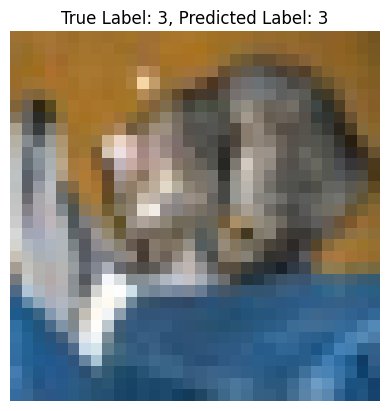

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the image tensor to a numpy array and transpose dimensions for matplotlib
img_np = img0.permute(1, 2, 0).cpu().numpy()

# Display the image
plt.imshow(img_np)
plt.title(f"True Label: {label0}, Predicted Label: {pred}")
plt.axis('off')
plt.show()

**Metrics Visualization**

Using 'val_acc' for Validation Acc (Post-Fine-tune)


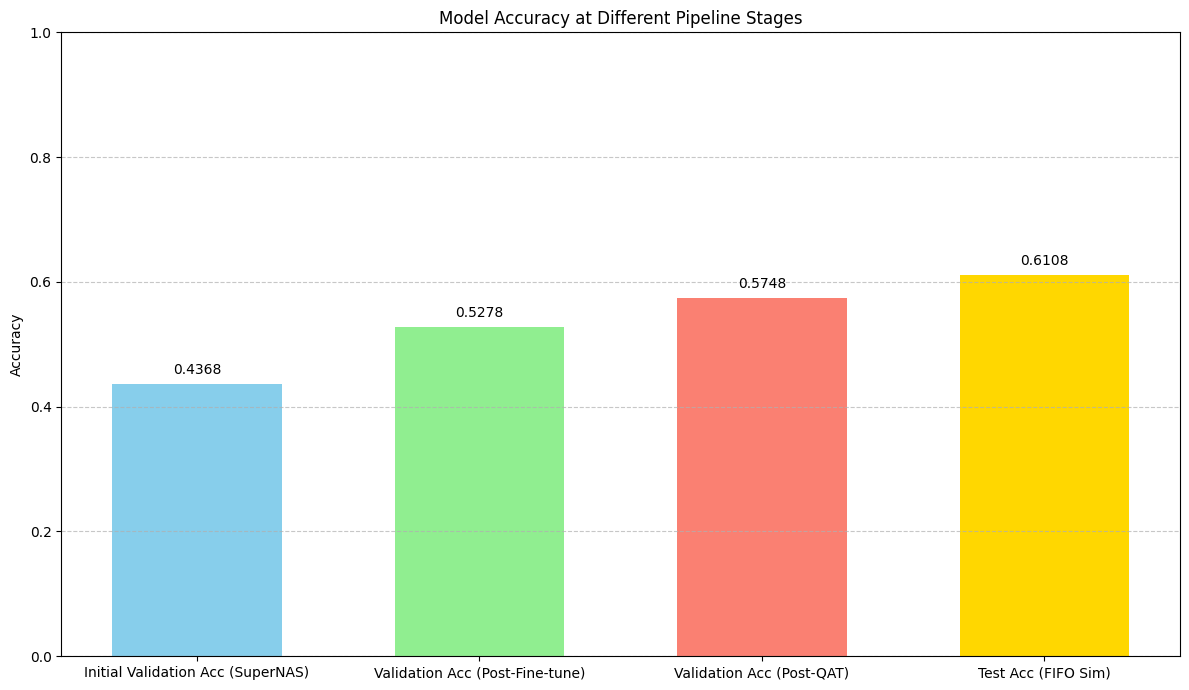


Other Metrics:
Parameter Count: 413706
Model Size (bytes): 1654824
Measured Sparsity: 0.000000


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results', 'best_acc', 'val_acc', and 'val_acc_post_qat', 'test_acc' are available

metrics_labels = ['Initial Validation Acc (SuperNAS)', 'Validation Acc (Post-Fine-tune)',
                  'Validation Acc (Post-QAT)', 'Test Acc (FIFO Sim)']

# Collect the accuracy values, handling potential missing values if quick_mode was used
accuracy_values = []

# Initial Validation Accuracy from SuperNAS search
accuracy_values.append(best_acc)

# Validation Accuracy after fine-tuning (check if val_acc from larger run exists, otherwise use post-prune if available, or post-qat if neither)
if 'val_acc' in globals():
    accuracy_values.append(val_acc)
    print("Using 'val_acc' for Validation Acc (Post-Fine-tune)")
elif 'val_acc_post_prune' in results:
     accuracy_values.append(results['val_acc_post_prune'])
     print("Using 'results['val_acc_post_prune']' for Validation Acc (Post-Fine-tune)")
else:
    accuracy_values.append(results['val_acc_post_qat']) # Fallback
    print("Using 'results['val_acc_post_qat']' for Validation Acc (Post-Fine-tune) as fallback")


# Validation Accuracy after QAT
accuracy_values.append(val_acc_post_qat)

# Test Accuracy
accuracy_values.append(test_acc)


x = np.arange(len(metrics_labels))
width = 0.6 # Increased width for better visibility

fig, ax = plt.subplots(figsize=(12, 7)) # Increased figure size
rects = ax.bar(x, accuracy_values, width, color=['skyblue', 'lightgreen', 'salmon', 'gold'])

# Add some text for labels, titles and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy at Different Pipeline Stages')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels, rotation=0, ha='center') # No rotation needed with wider plot
ax.set_ylim(0, 1) # Accuracy is between 0 and 1
ax.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid

# Add accuracy values on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

autolabel(rects)

fig.tight_layout()
plt.show()

# Also display parameter count, size, and sparsity
print("\nOther Metrics:")
print(f"Parameter Count: {results['param_count']}")
print(f"Model Size (bytes): {results['size_bytes']}")
# Check if the sparsity from the larger run is available, otherwise use the one from results
final_sparsity_value = compute_sparsity(loaded_model) if 'loaded_model' in globals() else results['sparsity']
print(f"Measured Sparsity: {final_sparsity_value:.6f}")